# Pronósticos, Round 2 - Parte 3: Prophet

## 1. Introducción

En la anterior versión de este proyecto, este análisis correspondió a la [parte 3](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/) de mis estimaciones, por lo que esta actualización toma como base dicho código, y únicamente actualizo la base de datos para incluir la nueva información que se ha generado al respecto. La *notebook* con el código completo de esta publicación se puede encontrar en mi repositorio de [Github](https://github.com/gonzalezhomar/articulos_pronosticos) o la pueden ver directamente [aquí](https://nbviewer.jupyter.org/github/gonzalezhomar/articulos_pronosticos/blob/main/PronR2_3.ipynb).

## 2. ¿Por qué Prophet?

Recordando, [*Prophet*](https://facebook.github.io/prophet/) es una herramienta de ciencia de datos desarrollada por el equipo de inteligencia artificial de Facebook y consiste en "un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de las vacaciones. Funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos. *Prophet* es robusto ante los datos faltantes y los cambios en la tendencia, y por lo general maneja bien los valores atípicos."

Como descubrí antes, una de las grandes ventajas es que *Prophet* realiza el análisis completo de manera automática, requiere mucho menos código que un análisis del tipo SARIMAX e incluso se pueden introducir pequeños ajustes manualmente leyendo [la documentación de *Prophet*](https://facebook.github.io/prophet/docs/quick_start.html#python-api). Con todas estas ventajas me era imposible dejar fuera a *Prophe*t.

En este nuevo round, tomaré como base el análisis estadístico hecho [en la parte 1](https://gonzalezhomar.netlify.app/post/pronr2_1sarimax/), dado que de momento solo tengo nuevas observaciones. Con ello, para el Impuesto al Valor Agregado (IVA) y para el Impuesto Sobre la Renta (ISR), utilizaré como variables explícativas el PIB y una dummy con la tasa del IVA o la reforma del ISR, respectivamente. En el resto de las series, haré el análisis de manera mensual. 

La *notebook* con el código completo de esta publicación se puede encontrar en mi repositorio de [Github](https://github.com/gonzalezhomar/articulos_pronosticos) o la pueden ver directamente [aquí](https://nbviewer.jupyter.org/github/gonzalezhomar/articulos_pronosticos/blob/main/PronR2_3.ipynb).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
import plotly.offline as py
import datapane as dp
dp.login(token='cf192a42f966041fe8e030aed38cb35ef8bddd10')

Connected successfully to https://datapane.com as gonzalezhomar


'gonzalezhomar'

In [2]:
import chart_studio
username = 'gonzalezhomar' # Add your username
api_key = 'TcVuJMUP1ovaJ05ERDxy' # Add your api key 
chart_studio.tools.set_credentials_file(username = username, api_key = api_key)

## 3. Series Trimestrales

Buscando no ser repetitivo, en esta parte iniciaré con las series trimestrales. Al igual que en mis otras publicaciones, solo dejaré comentarios completos para la serie de ISR, mientras que para la serie del IVA dejo el análisis con muchos menos comentarios. 

### 3.1 Impuesto Sobre la Renta, ISR

Para utilizar *Prophet*, los datos deben ser cargados con una columna *ds* que tenga las fechas en formato estandar y una variable *y* que incluya la serie a estimar. Los ajustes que incluí al modelo básico fueron los siguientes:
- Indiqué que la estacionalidad en multiplicativa.
- Incluí variables explícativas a *Prophet*, para lo cual consideré el PIB y la reforma ISR.
    
Para hacer el análisis, la serie se ajusta de manera automática con *Prophet* utilizando el siguiente código:

In [3]:
df = pd.read_csv('202108trimestrales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia       fechas  pib_real  pib_reale4     IPI  \
fecha                                                                   
2021-10-01  2021   10    1      2021/04  18725631  4681407.77  143.74   
2022-01-01  2022    1    1  2022/01 /r1  18021273  4505318.26  149.32   
2022-04-01  2022    4    1      2022/02  18331787  4582946.70  148.64   
2022-07-01  2022    7    1      2022/03  18308165  4577041.25  149.00   
2022-10-01  2022   10    1      2022/04  19118869  4779717.33  149.63   

            rfp_neta  isr  iva  rfp_real  isr_real  iva_real  tasa iva  \
fecha                                                                    
2021-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-01-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-04-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-07-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   

            reformaisr  covid      fecha  
fecha                                     
2021-10-01           1      0 2021-10-01  
2022-01-01           1      0 2022-01-01  
2022-04-01           1      0 2022-04-01  
2022-07-01           1      0 2022-07-01  
2022-10-01           1      0 2022-10-01

In [4]:
isr=df[['fecha','isr_real','pib_reale4','reformaisr']]
isr.columns=['ds','y','pib','reformaisr']
isr.dtypes

ds            datetime64[ns]
y                    float64
pib                  float64
reformaisr             int64
dtype: object

In [5]:
pron_isr=Prophet(seasonality_mode='additive')
pron_isr.add_regressor('pib')
pron_isr.add_regressor('reformaisr')
pron_isr.fit(isr)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


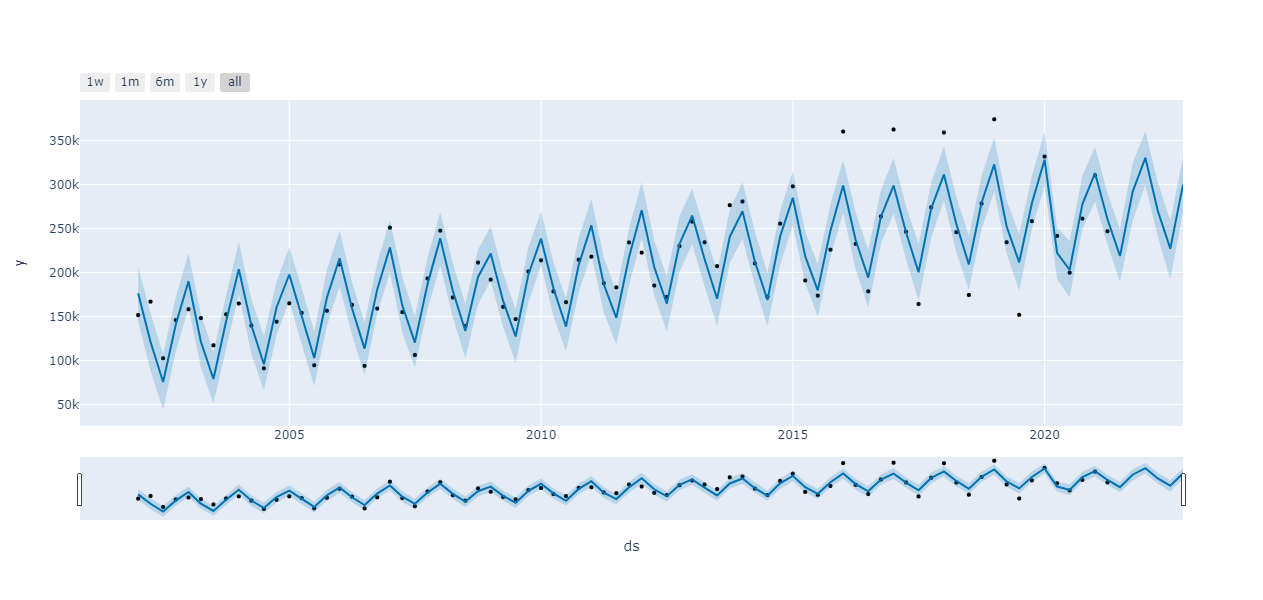

In [6]:
future = pron_isr.make_future_dataframe(periods=6)
future = future.merge(isr, on='ds')
fcst = pron_isr.predict(future)
py.init_notebook_mode()
fig=plot_plotly(pron_isr, fcst)
py.iplot(fig)

In [7]:
chart_studio.plotly.plot(fig, filename='isr_prophet', auto_open=True)
fig.write_html('ISR.html')

De hecho, se puede desagregar el pronóstico resultante de Prophet en sus componentes: tendencia, parte estacional y la parte correspondiente a las variables explícativas:

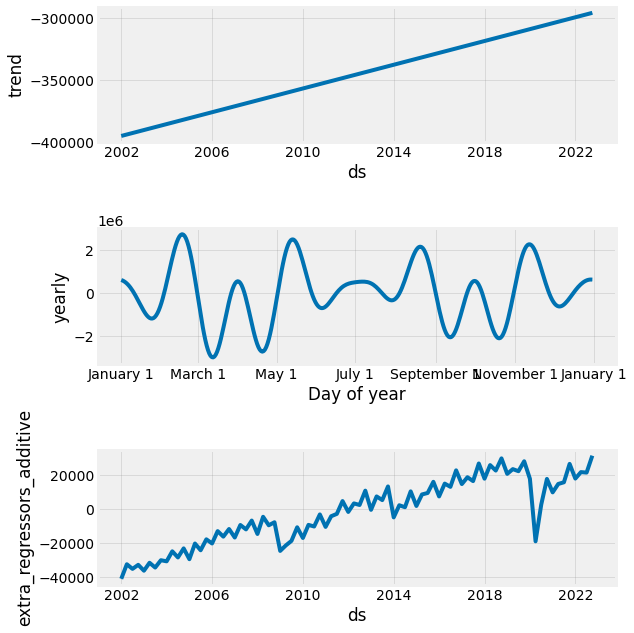

In [8]:
fig=pron_isr.plot_components(fcst)

In [9]:
fcst.to_csv('prophet_isr.csv')

### 3.2 Impuesto al Valor Agregado, IVA

In [10]:
iva=df[['fecha','iva_real','pib_reale4','tasa iva']]
iva.dtypes
iva.columns=['ds','y','pib','tasa iva']
iva.tail(8)

ds           y         pib  tasa iva
fecha                                                  
2021-01-01 2021-01-01  180536.600  4340383.68        16
2021-04-01 2021-04-01  198732.452  4440839.82        16
2021-07-01 2021-07-01         NaN  4461053.85        16
2021-10-01 2021-10-01         NaN  4681407.77        16
2022-01-01 2022-01-01         NaN  4505318.26        16
2022-04-01 2022-04-01         NaN  4582946.70        16
2022-07-01 2022-07-01         NaN  4577041.25        16
2022-10-01 2022-10-01         NaN  4779717.33        16

In [11]:
pron_iva=Prophet(seasonality_mode='multiplicative') #,changepoints=['2010-01-01']
pron_iva.add_regressor('pib')
pron_iva.add_regressor('tasa iva')
pron_iva.fit(iva)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


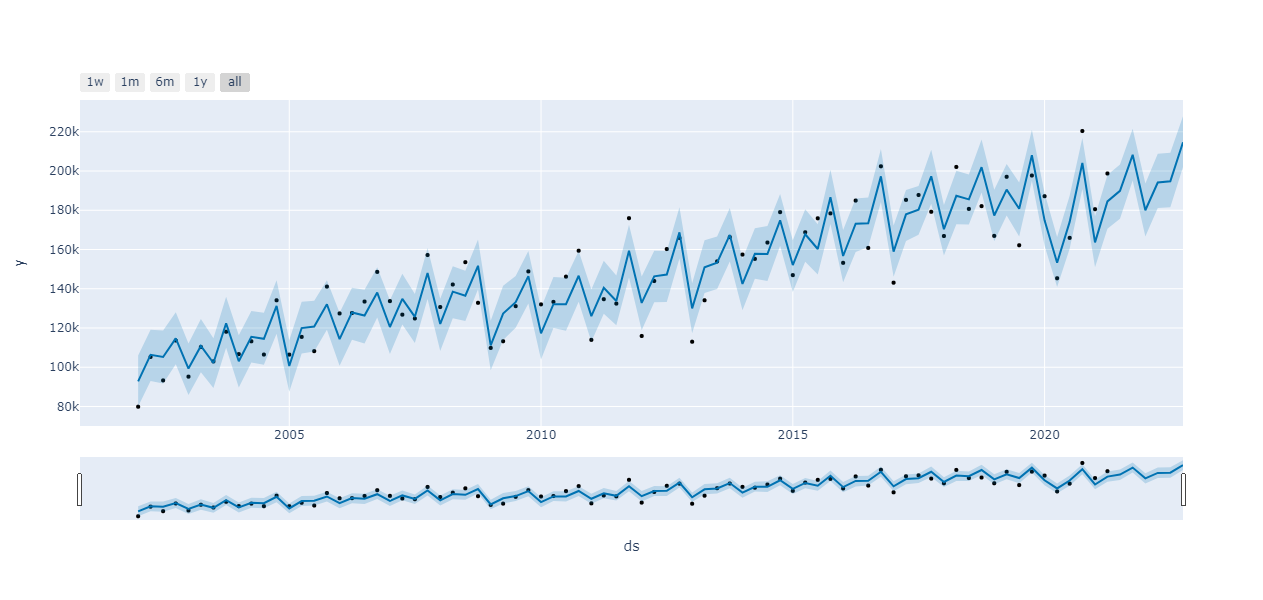

In [12]:
future = pron_iva.make_future_dataframe(periods=6)
future = future.merge(iva, on='ds')
fcst = pron_iva.predict(future)
fig=plot_plotly(pron_iva, fcst)
py.iplot(fig)

In [13]:
chart_studio.plotly.plot(fig, filename='iva_prophet', auto_open=True)
fig.write_html('IVA.html')

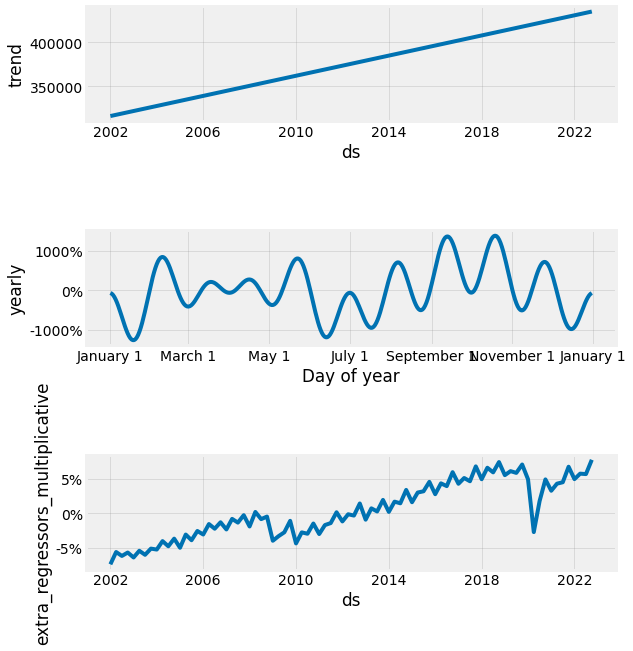

In [14]:
fig=pron_iva.plot_components(fcst)

In [15]:
fcst.to_csv('prophet_iva.csv')

In [16]:
chart_studio.plotly.plot?

Signature: chart_studio.plotly.plot(figure_or_data, validate=True, **plot_options)
Docstring:
Create a unique url for this plot in Plotly and optionally open url.

plot_options keyword arguments:
filename (string) -- the name that will be associated with this figure
fileopt ('new' | 'overwrite' | 'extend' | 'append') -- 'new' creates a
    'new': create a new, unique url for this plot
    'overwrite': overwrite the file associated with `filename` with this
    'extend': add additional numbers (data) to existing traces
    'append': add additional traces to existing data lists
auto_open (default=True) -- Toggle browser options
    True: open this plot in a new browser tab
    False: do not open plot in the browser, but do return the unique url
sharing ('public' | 'private' | 'secret') -- Toggle who can view this
                                              graph
    - 'public': Anyone can view this graph. It will appear in your profile
                and can appear in search engines. 

## 4. Series Mensuales

Ahora bien, para el análisis de las series mensuales comenzaré con el IEPS Cervezas. El resto de las series mensuales tienen comentarios, solo dejaré los principales resultados.

### 4.1 IEPS Cervezas

Para utilizar *Prophet* en las series mensuales, el código es incluso más simple que en el análisis trimestral debido a que no tengo variables explícativas y solo hay que adecuar la frecuencia. De hecho, el código para hacer el análisis, y generar su respectiva gráfica es el siguiente:

In [17]:
df = pd.read_csv('202107mensuales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia  fechas  ieps_gas  ieps_tabacos  ieps_bebidas  \
fecha                                                                      
2022-08-01  2022    8    1  ago-22       NaN           NaN           NaN   
2022-09-01  2022    9    1  sep-22       NaN           NaN           NaN   
2022-10-01  2022   10    1  oct-22       NaN           NaN           NaN   
2022-11-01  2022   11    1  nov-22       NaN           NaN           NaN   
2022-12-01  2022   12    1  dic-22       NaN           NaN           NaN   

            ieps_cervezas  ieps_bebidassab  ieps_alimentos  importacion  \
fecha                                                                     
2022-08-01            NaN              NaN             NaN          NaN   
2022-09-01            NaN              NaN             NaN          NaN   
2022-10-01            NaN              NaN             NaN          NaN   
2022-11-01            NaN              NaN             NaN          NaN   
2022-12-01            NaN              NaN             NaN          NaN   

            rfp_petroleros      fecha  
fecha                                  
2022-08-01             NaN 2022-08-01  
2022-09-01             NaN 2022-09-01  
2022-10-01             NaN 2022-10-01  
2022-11-01             NaN 2022-11-01  
2022-12-01             NaN 2022-12-01

In [18]:
iepsc2=df[['fecha','ieps_cervezas']]
iepsc=iepsc2.dropna()
iepsc.columns=['ds','y']
iepsc.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


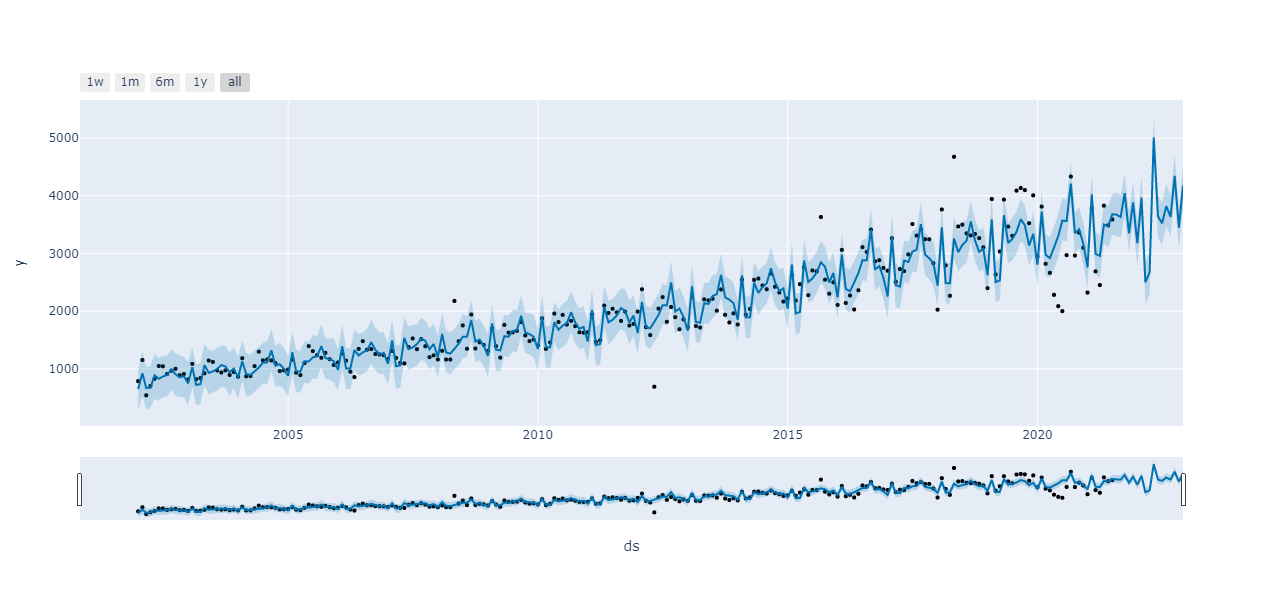

In [19]:
proniepsc=Prophet(seasonality_mode='multiplicative').fit(iepsc)
future = proniepsc.make_future_dataframe(periods=17, freq='M')
fcst = proniepsc.predict(future)
fig=plot_plotly(proniepsc, fcst)
py.iplot(fig)

In [20]:
chart_studio.plotly.plot(fig, filename='iepsc_prophet', auto_open=True)
fig.write_html('IEPS_C.html')

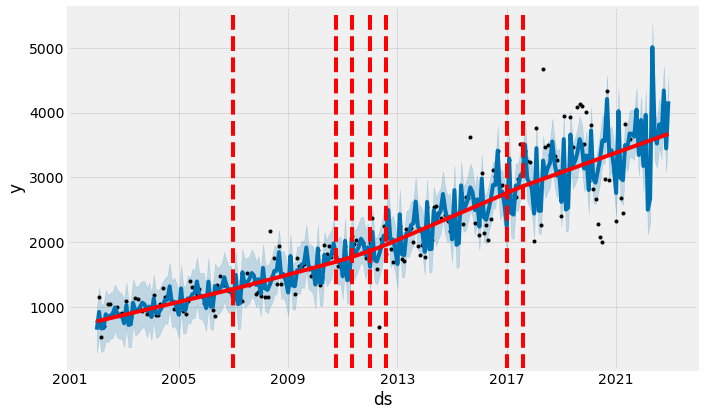

In [21]:
fig=proniepsc.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsc,fcst)

In [22]:
fcst.to_csv('prophet_iepsc.csv')

### 4.2 IEPS Bebidas

In [23]:
iepsb2=df[['fecha','ieps_bebidas']]
iepsb=iepsb2.dropna()
iepsb.columns=['ds','y']
iepsb.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


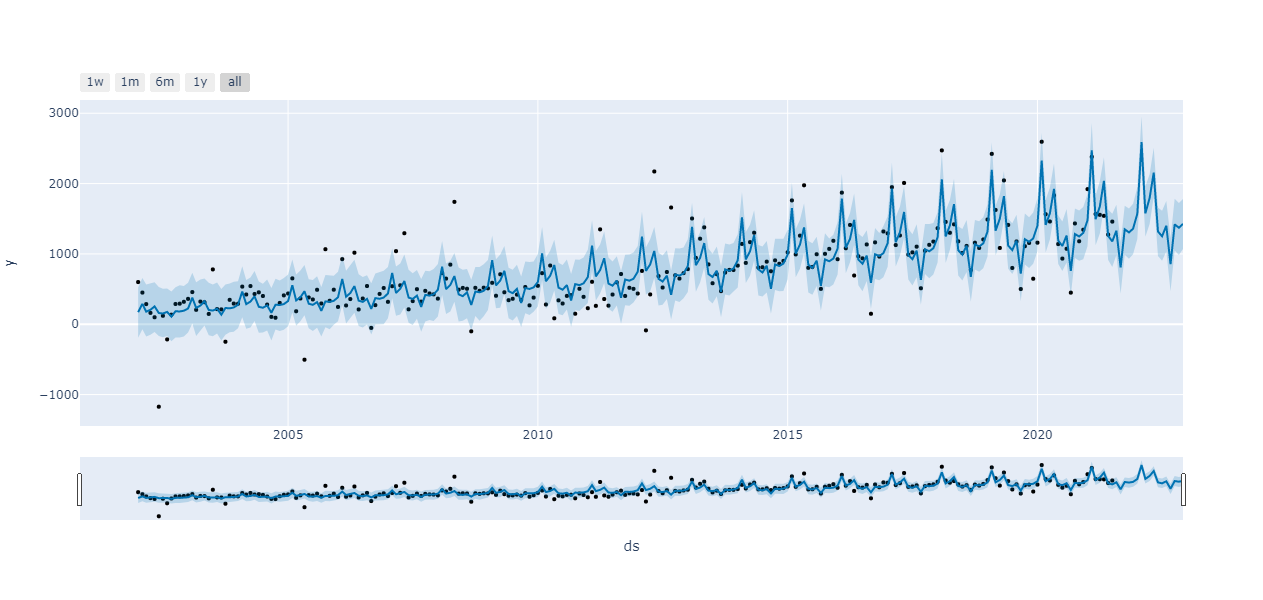

In [24]:
proniepsb=Prophet(seasonality_mode='multiplicative').fit(iepsb)
future = proniepsb.make_future_dataframe(periods=17, freq='M')
fcst = proniepsb.predict(future)
fig=plot_plotly(proniepsb, fcst)
py.iplot(fig)

In [25]:
chart_studio.plotly.plot(fig, filename='iepsb_prophet', auto_open=True)
fig.write_html('IEPS_B.html')

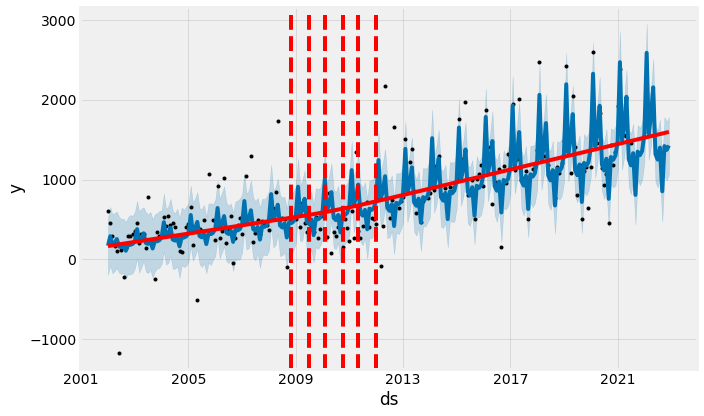

In [26]:
fig=proniepsb.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsb,fcst)

In [28]:
fcst.to_csv('prophet_iepsb.csv')

### 4.3 IEPS Tabacos

In [29]:
iepst2=df[['fecha','ieps_tabacos']]
iepst=iepst2.dropna()
iepst.columns=['ds','y']
iepst.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


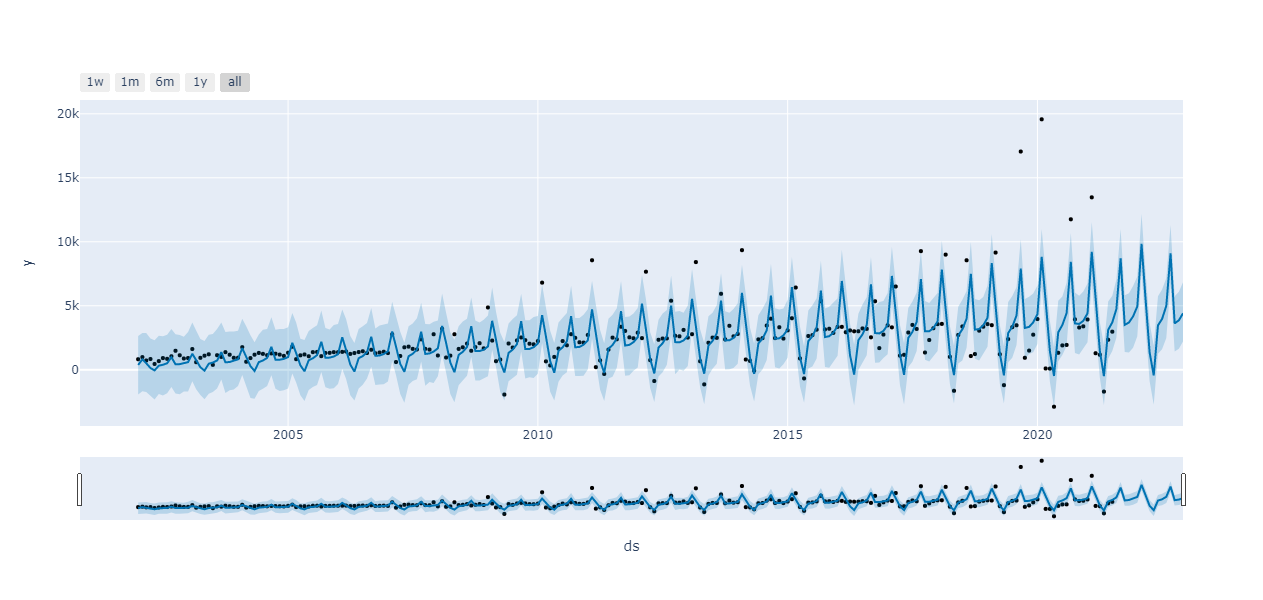

In [30]:
proniepst=Prophet(seasonality_mode='multiplicative').fit(iepst)
future = proniepst.make_future_dataframe(periods=17, freq='M')
fcst = proniepst.predict(future)
fig=plot_plotly(proniepst, fcst)
py.iplot(fig)

In [31]:
chart_studio.plotly.plot(fig, filename='iepst_prophet', auto_open=True)
fig.write_html('IEPS_T.html')

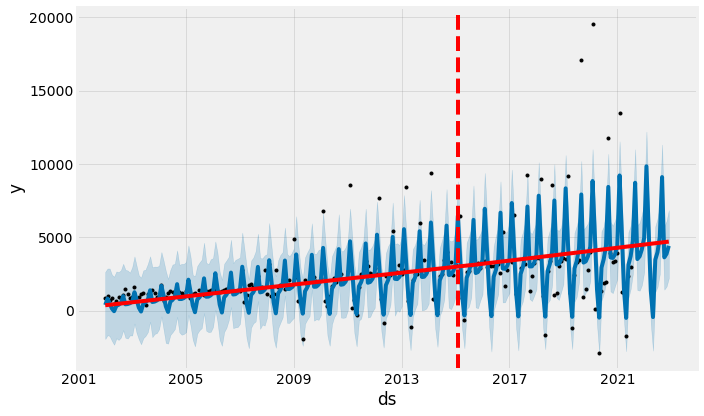

In [32]:
fig=proniepst.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepst,fcst)

In [33]:
fcst.to_csv('prophet_iepst.csv')

### 4.4 IEPS Gasolinas y Diésel

In [34]:
iepsg2=df[['fecha','ieps_gas']]
iepsg=iepsg2.dropna()
iepsg.columns=['ds','y']
iepsg.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


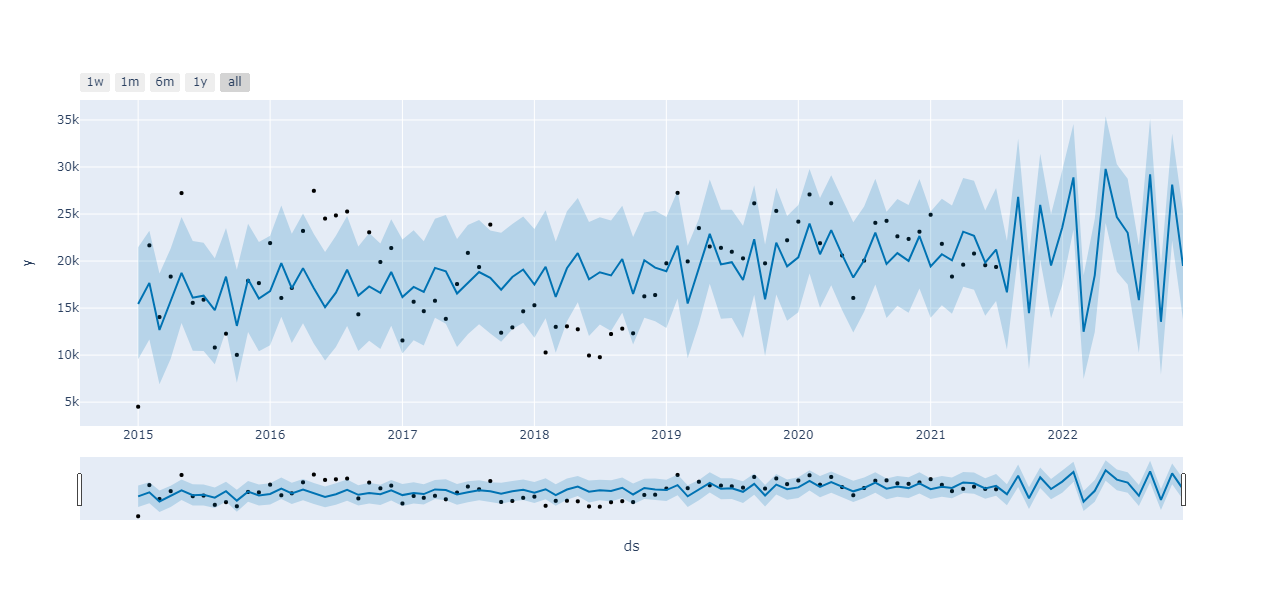

In [35]:
proniepsg=Prophet(seasonality_mode='multiplicative').fit(iepsg)
future = proniepsg.make_future_dataframe(periods=17, freq='M')
fcst = proniepsg.predict(future)
fig=plot_plotly(proniepsg, fcst)
py.iplot(fig)

In [36]:
chart_studio.plotly.plot(fig, filename='iepsg_prophet', auto_open=True)
fig.write_html('IEPS_G.html')

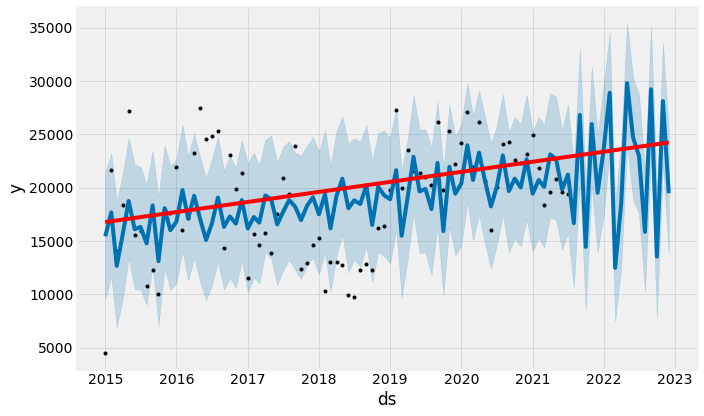

In [37]:
fig=proniepsg.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsg,fcst)

In [38]:
fcst.to_csv('prophet_iepsg.csv')

### 4.5 IEPS Bebidas Saborizadas

In [39]:
iepsbs2=df[['fecha','ieps_bebidassab']]
iepsbs=iepsbs2.dropna()
iepsbs.columns=['ds','y']
iepsbs.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


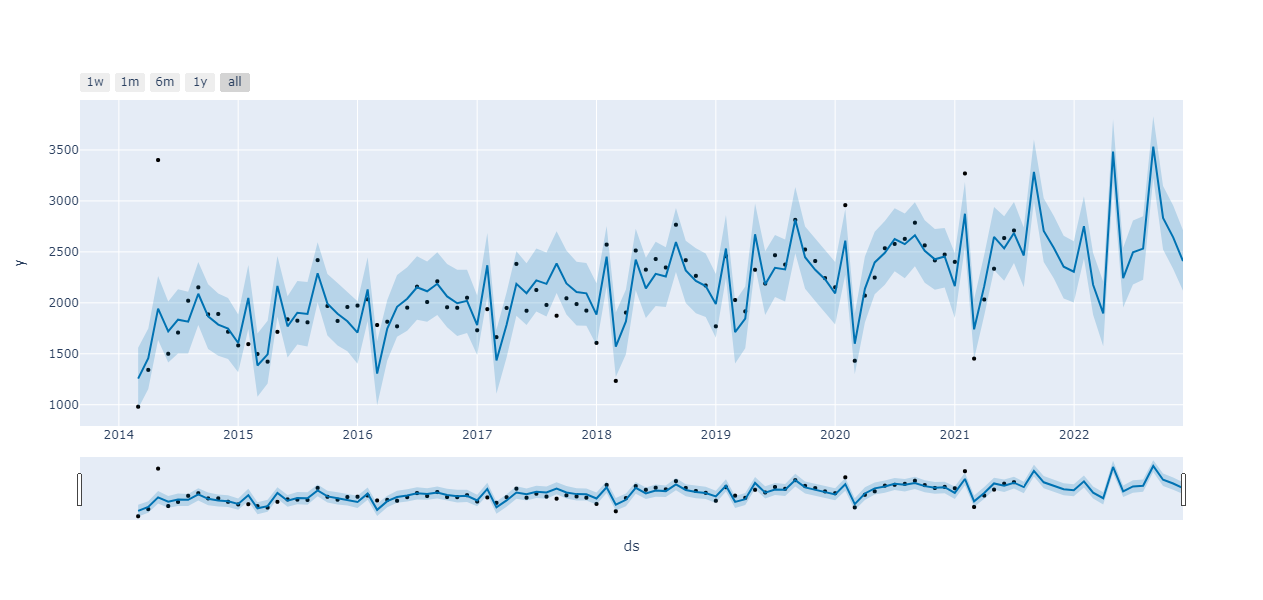

In [40]:
proniepsbs=Prophet(seasonality_mode='multiplicative').fit(iepsbs)
future = proniepsbs.make_future_dataframe(periods=17, freq='M')
fcst = proniepsbs.predict(future)
fig=plot_plotly(proniepsbs, fcst)
py.iplot(fig)

In [41]:
chart_studio.plotly.plot(fig, filename='iepsbs_prophet', auto_open=True)
fig.write_html('IEPS_BS.html')

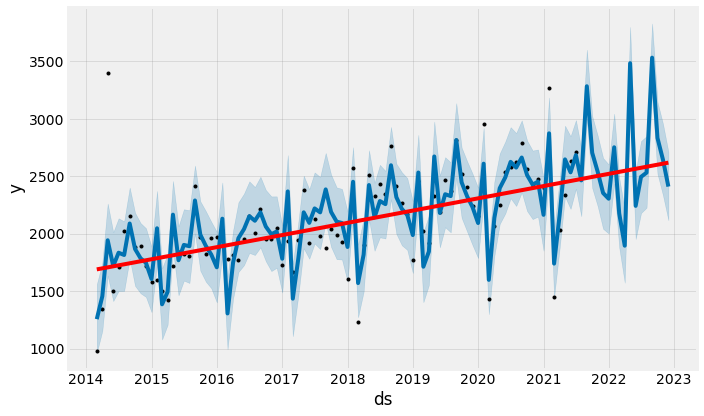

In [42]:
fig=proniepsbs.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsbs,fcst)

In [43]:
fcst.to_csv('prophet_iepsbs.csv')

### 4.6 IEPS Alimentos

In [44]:
iepsa2=df[['fecha','ieps_alimentos']]
iepsa=iepsa2.dropna()
iepsa.columns=['ds','y']
iepsa.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


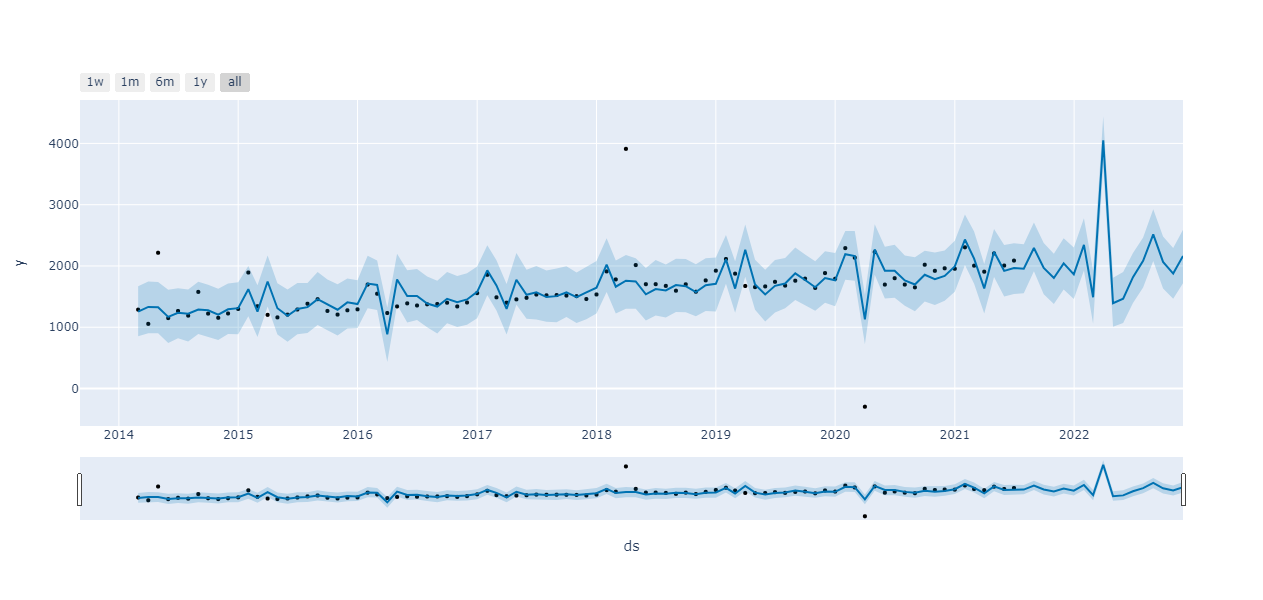

In [45]:
proniepsa=Prophet(seasonality_mode='multiplicative').fit(iepsa)
future = proniepsa.make_future_dataframe(periods=17, freq='M')
fcst = proniepsa.predict(future)
fig=plot_plotly(proniepsa, fcst)
py.iplot(fig)

In [46]:
chart_studio.plotly.plot(fig, filename='iepsa_prophet', auto_open=True)
fig.write_html('IEPS_A.html')

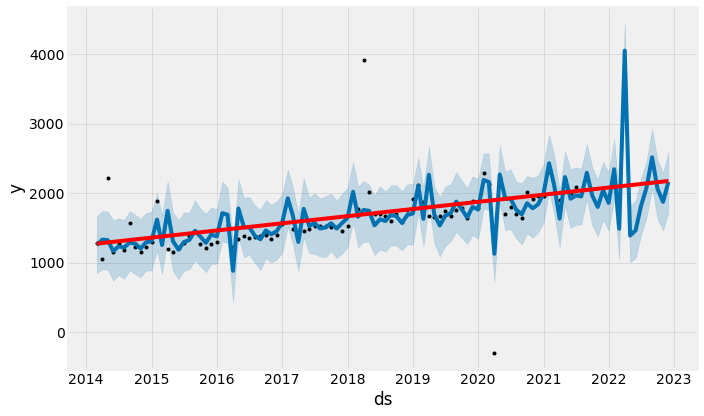

In [47]:
fig=proniepsa.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),proniepsa,fcst)

In [48]:
fcst.to_csv('prophet_iepsa.csv')

### 4.7 Importacion

In [49]:
importacion2=df[['fecha','importacion']]
importacion=importacion2.dropna()
importacion.columns=['ds','y']
importacion.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


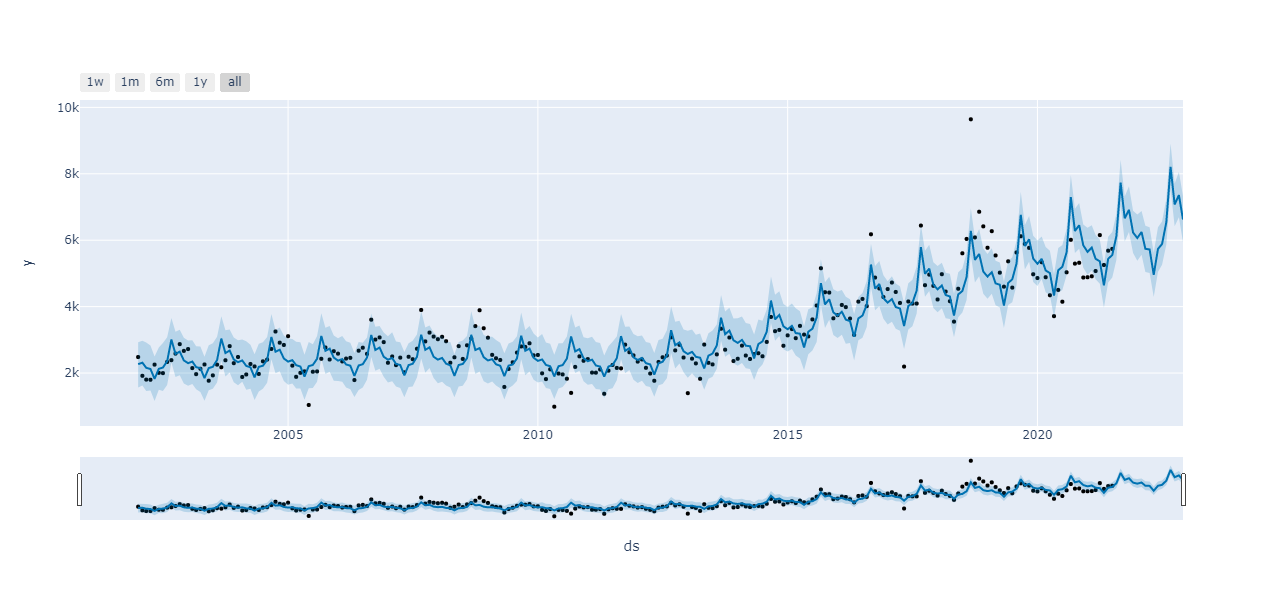

In [50]:
pronimportacion=Prophet(seasonality_mode='multiplicative').fit(importacion)
future = pronimportacion.make_future_dataframe(periods=17, freq='M')
fcst = pronimportacion.predict(future)
fig=plot_plotly(pronimportacion, fcst)
py.iplot(fig)

In [51]:
chart_studio.plotly.plot(fig, filename='importacion_prophet', auto_open=True)
fig.write_html('importacion.html')

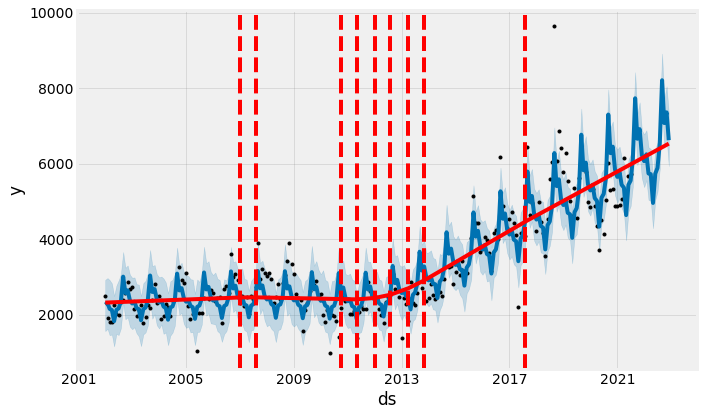

In [52]:
fig=pronimportacion.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),pronimportacion,fcst)

In [53]:
fcst.to_csv('prophet_importacion.csv')

### 4.8 Ingresos Petroleros

In [54]:
petr2=df[['fecha','rfp_petroleros']]
petr=petr2.dropna()
petr.columns=['ds','y']
petr.dtypes

ds    datetime64[ns]
y            float64
dtype: object

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


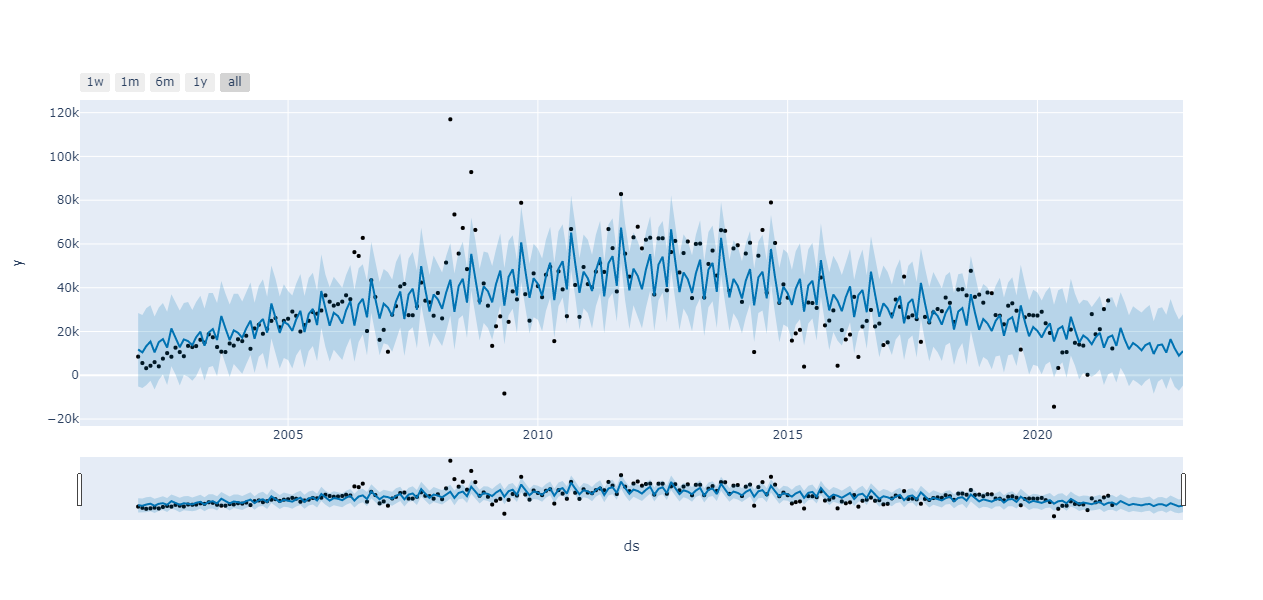

In [55]:
pronpetr=Prophet(seasonality_mode='multiplicative').fit(petr)
future = pronpetr.make_future_dataframe(periods=17, freq='M')
fcst = pronpetr.predict(future)
fig=plot_plotly(pronpetr, fcst)
py.iplot(fig)

In [56]:
chart_studio.plotly.plot(fig, filename='petroleros_prophet', auto_open=True)
fig.write_html('Petroleros.html')

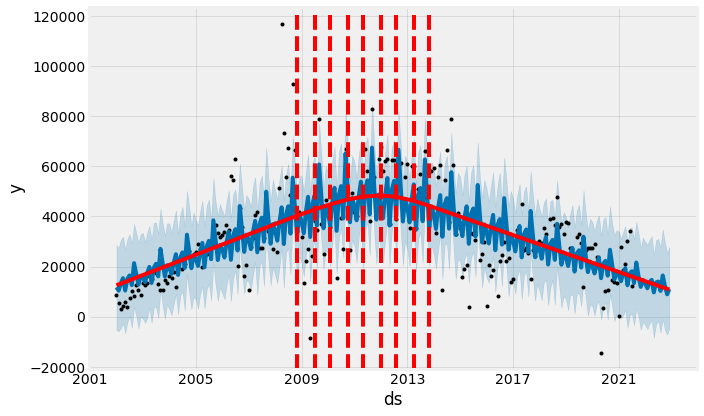

In [57]:
fig=pronpetr.plot(fcst)
a=add_changepoints_to_plot(fig.gca(),pronpetr,fcst)

In [58]:
fcst.to_csv('prophet_petr.csv')

### 5. Conclusiones

Para ver las conclusiones sugiero revisar el respectivo blog [aquí](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/)